# Entropy and complexity feature definitions

This calculation reproduces the results of "History of art paintings through the lens of entropy and complexity" Higor Y. D. Sigakia, Matjaz Percb, and Haroldo V. Ribeiro. 

In [1]:
from PIL import Image
from PIL import ImagePalette
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [3]:
 def display_image(img):
    '''
    Displays the image loaded from folder in the notebook
    input: 
        img: image name as it appears in the data file 
    output: image display
    '''
    myimage = Image.open(img)
    
    #myimage
    
    return myimage

## Sliding matrices
A sliding submatrix of a matrix A is defined the following way. For a matrix A with dimentions (n,m):

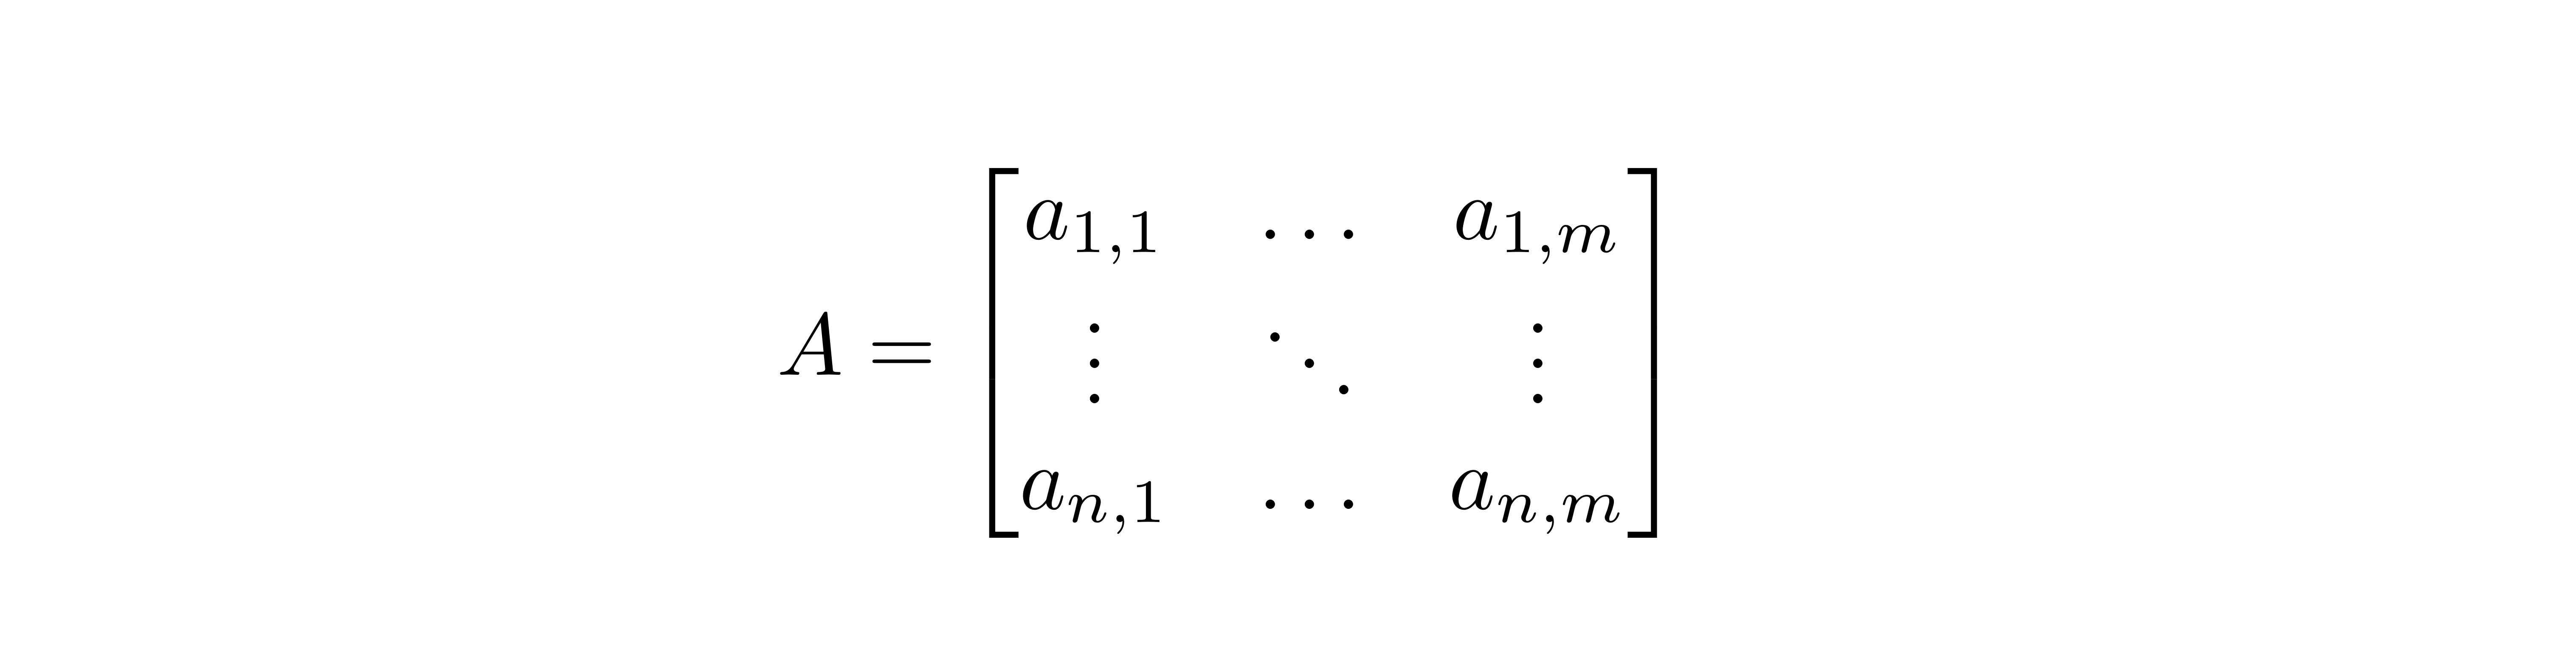

In [4]:
display_image('matrix_def.png')

Then a submatrix A_{i,j} will be defined the following way:

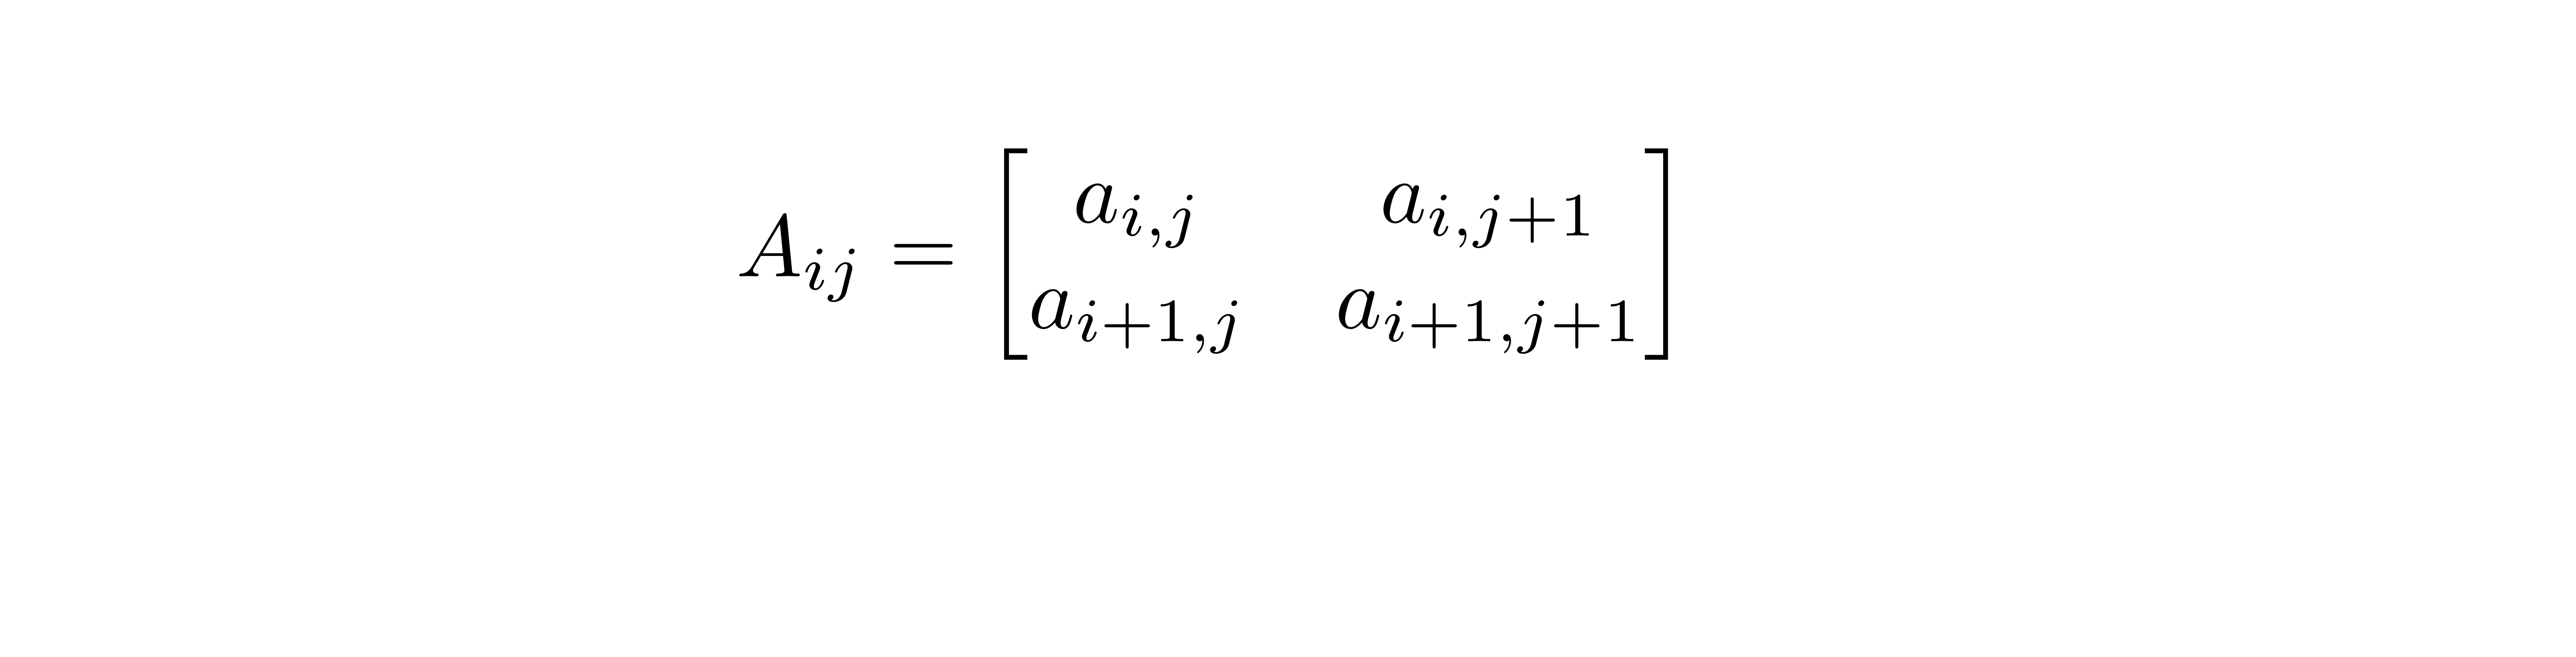

In [5]:
display_image('Sliding_submatrix.png')

In [6]:
def create_sliding_matrices(color_array, height, width):
    '''
    Computes the array of all sliding 2x2 submatrices from a given matrix.
    Input:
        color_array: an array of pixel properties (color, intencity, etc). For our case one of the RGB channels is used. 
        width: int, width of the painting (pixels)
        height: int, height of the painting (pixels)
    output: 
        array of matrices 2x2. Shape ((width-1)*(height-1),2,2)
        
    '''
    matrix_array = np.zeros(shape = (height - 1, width - 1, 2, 2))
    col_mat = np.array(color_array).astype(int).reshape((height, width))
            
    for i in range(0, height - 1):
        for j in range(0, width - 1):
            matrix_array[i, j] = col_mat[np.ix_([i, i + 1],
                                                [j, j + 1])].astype(int)
    return(matrix_array)

 ## Matrix permutation distribution

A permutation of the elements in the maetrix is the order of the elements of the matrix. Each of the 2x2 matrices produces a permutation.

In [7]:
def compute_permutation(matrix):
    '''Computes the permutation associated with the 2x2 matrix.
    input: 
        matrix: np.array of a matrix
    output: 
        perm: permutation array with the same length as number of elements in matrix.
    '''
    permutation = np.argsort(matrix.flatten())
    return permutation

Permutation of all matrice produce a distribution. Note that for 4 elements there are 24 possible permutations.

In [8]:
def permutataion_distribution(matrix_list):
    '''
    Returns the distribution of matrix permutaions.
    Input: 
        matrix_list: the output of sliding_matrix.
    output: 
        num_of_perm: list of numebr of each permutations in order recieved
        list_of_perm: list of permutations in order recieved
        distribution: distrubution
        
    '''
    list_of_perm = []
    num_of_perm = []
    distribution = np.zeros(24)
    for i in matrix_list:
        mat_perm = compute_permutation(np.array(i))
        indicator = 0
        for j in range(0, len(list_of_perm)):
            if np.all(mat_perm == list_of_perm[j]):
                num_of_perm[j] = num_of_perm[j] + 1
                indicator = 1
        if indicator == 0:
            list_of_perm.append(mat_perm)
            num_of_perm.append(1)
            
    distribution = np.array(num_of_perm) / sum(num_of_perm)
    return num_of_perm, list_of_perm, distribution
    

## Entropy and complexity

In [9]:
def compute_entropy(distribution):
    '''
    Compute normalised Shannon entropy from distribution
    '''
    Shannon_entropy = -np.sum(distribution * np.log2(distribution))
    return Shannon_entropy

In [10]:
def normalise_entropy(distribution):
    '''
    Compute normalised Shannon entropy from distribution
    '''
    Shannon_norm = -np.sum(distribution * np.log2(distribution)) / np.log2(len(distribution))
    return Shannon_norm

In [26]:
def compute_complexity(distribution):
    '''Statistical Complexity from distribution'''
    comp = compute_divergence(distribution) * normalise_entropy(distribution) / find_norm_constant(distribution)

    return comp

In [24]:
def compute_divergence(distribution):
    '''Jensen-Shannon divergence'''
    n = len(distribution)
    uniform = np.array([1/n] * n)
    div = compute_entropy((distribution + uniform)/2) - compute_entropy(distribution)/2 - compute_entropy(uniform)/2
    return div

In [40]:
def find_norm_constant(distribution):
    '''Normalisation constant D*'''
    n = len(distribution)
    const = -0.5 * (((n + 1) / n) * np.log(n + 1) + np.log(n) - 2 * np.log(2 * n))
    return const

In [41]:
def produce_entropy_complexity(name):
    '''
    Entropy and complexity computations.
    input: 
        name: input painting name.
    output:
        Entr
    '''
    img1 = cv2.imread(name)
    myimage = display_image(name)
    
    painting_width, painting_height = myimage.size
    b, g, r = cv2.split(img1)
    
    b = pd.Series(b.flatten(), dtype='int')
    g = pd.Series(g.flatten(), dtype='int')
    r = pd.Series(r.flatten(), dtype='int')
    colors = np.array([r, g, b]).astype(int)
    
    entr = []
    compl = []
    
    for i in range(0, len(colors)):
        
        sliding_matrix = create_sliding_matrices(colors[i],
                                                 painting_height,
                                                 painting_width).reshape(((painting_height - 1) * (painting_width-1),
                                                                   2,
                                                                   2))
        res1 = permutataion_distribution(sliding_matrix)
        entr.append(normalise_entropy(res1[2]))
        compl.append(compute_complexity(res1[2]))

    return entr, compl

In [15]:
#[x2,y2] = entropy_compl('cezannne.jpg')

# Data Frame

The collection of paintings used is from Centenary Exhibition of Impressionists, 1874. The painting images are collected mostly from Wikipedia Commons. The width and the height of the painting are given in cm.

In [16]:
df = pd.read_excel(r'CentenaryExhibition.xlsx')

In [17]:
df.head()

,Author name,Painting name,year,file name,width,height,url,Unnamed: 7
0,Frederic Bazille,View of the Village,1868,"Bazille,_Frederic___View_of_the_Village,_1868.jpg",85.00,137.50,https://commons.wikimedia.org/wiki/File:Bazill...,NaN
1,Eugene Boudin,The Coast Near Portrieux,1874,Eugene_Boudin_-_Rivage_de_Portrieux_(Cotes-du-...,85.00,148.00,https://commons.wikimedia.org/wiki/File:Eug%C3...,NaN
2,Gustave Caillebotte,Boulevard Seen from Above,1880,Boulevard_Seen_from_Above.jpg,54.00,65.00,https://www.reddit.com/r/museum/comments/5ndw1...,NaN
3,Mary Cassat,A Woman in Black at the Opera,1978,Mary_Stevenson_Cassatt_-_In_the_Loge_-_Google_...,66.04,81.28,https://commons.wikimedia.org/wiki/File:Mary_S...,NaN
4,Paul Cezanne,The Black Clock,1870,"La_Pendule_noire,_par_Paul_Cezanne.jpg",73.00,54.00,https://commons.wikimedia.org/wiki/File:La_Pen...,NaN


In [18]:
np.unique(df['Author name '])

array(['Alfred Sisley', 'Berthe Morisot', 'Camille Pissarro',
       'Claude Monet', 'Edgar Degas', 'Edouard Manet', 'Eugene Boudin',
       'Frederic Bazille ', 'Gustave Caillebotte', 'Mary Cassat',
       'Paul Cezanne', 'Pierre Auguste Renoir'], dtype=object)

In [42]:
entropy_list = np.zeros(shape = (len(df), 3))
complexity_list = np.zeros(shape = (len(df), 3))

In [31]:
[entropy_list[0], complexity_list[0]] = produce_entropy_complexity('data_1/' + df['file name'][0])